# SIGNAL PROCESSING WITH GW150914 OPEN DATA 

Welcome! This ipython notebook (or associated python script GW150914_tutorial.py ) will go through some typical signal processing tasks on strain time-series data associated with the LIGO GW150914 data release from the LIGO Open Science Center (LOSC):

* https://losc.ligo.org/events/GW150914/

* View the tutorial as a web page - https://losc.ligo.org/s/events/GW150914/GW150914_tutorial.html/
* Download the tutorial as a python script - https://losc.ligo.org/s/events/GW150914/GW150914_tutorial.py/
* Download the tutorial as iPython Notebook - https://losc.ligo.org/s/events/GW150914/GW150914_tutorial.ipynb/

To begin, download the ipython notebook, readligo.py, and the data files listed below, into a directory / folder, then run it. Or you can run the python script GW150914_tutorial.py. You will need the python packages: numpy, scipy, matplotlib, h5py.

On Windows, or if you prefer, you can use a python development environment such as Anaconda (https://www.continuum.io/why-anaconda) or Enthought Canopy (https://www.enthought.com/products/canopy/). 

Questions, comments, suggestions, corrections, etc: email losc@ligo.caltech.edu

v20160208b

## Below my comments come after **  
## -XH

## ** Before we start:

    enpkg matplotlib
    enpkg hdf5
    # useful python functions
    wget https://losc.ligo.org/s/sample_code/readligo.py  # if this doesn't work, download using a web brower
    # download data
    wget https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_4_V1-1126259446-32.hdf5
    wget https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_16_V1-1126259446-32.hdf5
    wget https://losc.ligo.org/s/events/GW150914/L-L1_LOSC_16_V1-1126259446-32.hdf5
    wget https://losc.ligo.org/s/events/GW150914/L-L1_LOSC_4_V1-1126259446-32.hdf5
    wget https://losc.ligo.org/s/events/GW150914/GW150914_4_NR_waveform.txt

In [14]:
# ** The paper
from IPython.core.display import HTML
HTML('<iframe src=https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.116.061102 width=1000 height=700></iframe>')


## Intro to signal processing

This tutorial assumes that you know python well enough. 

If you know how to use "ipython notebook", use the GW150914_tutorial.ipynb file. Else, you can use the GW150914_tutorial.py script.

This tutorial assumes that you know a bit about signal processing of digital time series data (or want to learn!). This includes power spectral densities, spectrograms, digital filtering, whitening, audio manipulation. This is a vast and complex set of topics, but we will cover many of the basics in this tutorial.

If you are a beginner, here are some resources from the web:
* http://101science.com/dsp.htm
* https://georgemdallas.wordpress.com/2014/05/14/wavelets-4-dummies-signal-processing-fourier-transforms-and-heisenberg/
* https://en.wikipedia.org/wiki/Signal_processing
* https://en.wikipedia.org/wiki/Spectral_density
* https://en.wikipedia.org/wiki/Spectrogram
* http://greenteapress.com/thinkdsp/
* https://en.wikipedia.org/wiki/Digital_filter

And, well, lots more - google it!

## Download the data

* Download the data files from LOSC:
* We will use the hdf5 files, both H1 and L1, with durations of 32 and 4096 seconds around GW150914, sampled at 16384 and 4096 Hz :
  * https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_4_V1-1126259446-32.hdf5
  * https://losc.ligo.org/s/events/GW150914/L-L1_LOSC_4_V1-1126259446-32.hdf5
  * https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_16_V1-1126259446-32.hdf5
  * https://losc.ligo.org/s/events/GW150914/L-L1_LOSC_16_V1-1126259446-32.hdf5
  * https://losc.ligo.org/s/events/GW150914/GW150914_4_NR_waveform.txt
* Download the python functions to read the data: https://losc.ligo.org/s/sample_code/readligo.py
* From a unix/mac-osx command line, you can use wget; for example, 
  * wget https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_4_V1-1126257414-4096.hdf5
* Put these files in your current directory / folder. Don't mix any other LOSC data files in this directory, or readligo.py may get confused.

Here, 
* "H-H1" means that the data come from the LIGO Hanford Observatory site and the LIGO "H1" datector; 
* the "_4_" means the strain time-series data are (down-)sampled from 16384 Hz to 4096 Hz;
* the "V1" means version 1 of this data release;
* "1126257414-4096" means the data starts at GPS time 1126257414 (Mon Sep 14 09:16:37 GMT 2015), duration 4096 seconds;
  * NOTE: GPS time is number of seconds since Jan 6, 1980 GMT. See http://www.oc.nps.edu/oc2902w/gps/timsys.html or https://losc.ligo.org/gps/ 
* the filetype "hdf5" means the data are in hdf5 format:
https://www.hdfgroup.org/HDF5/

Note that the the 4096 second long files at 16384 Hz sampling rate are fairly big files (125 MB). 
You won't need them for this tutorial:
* https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_4_V1-1126257414-4096.hdf5
* https://losc.ligo.org/s/events/GW150914/L-L1_LOSC_4_V1-1126257414-4096.hdf5
* https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_16_V1-1126257414-4096.hdf5
* https://losc.ligo.org/s/events/GW150914/L-L1_LOSC_16_V1-1126257414-4096.hdf5


In [15]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

# the ipython magic below must be commented out in the .py file, since it doesn't work.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

# LIGO-specific readligo.py 
import readligo as rl

**NOTE** that in general, LIGO strain time series data has gaps (filled with NaNs) when the detectors are not taking valid ("science quality") data. Analyzing these data requires the user to loop over "segments" of valid data stretches. In https://losc.ligo.org/segments/ we provide example code to do this. 

**However**, the 4096 seconds of released data around GW150914 is one unbroken segment, with no gaps. So for now, we will read it all in and treat it as one valid data segment, ignoring the extra complexity mentioned above.

**This won't work** for other LOSC data releases! See https://losc.ligo.org/segments/ for a more general way to find valid data segments in LOSC data.

In [16]:
#----------------------------------------------------------------
# Load LIGO data from a single file
#----------------------------------------------------------------
# First from H1
fn_H1 = 'H-H1_LOSC_4_V1-1126259446-32.hdf5'
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
# and then from L1
fn_L1 = 'L-L1_LOSC_4_V1-1126259446-32.hdf5'
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

# sampling rate:  (**We've seen something similar in CP-I)
fs = 4096
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)  (**We've seen this this semester!)
dt = time[1] - time[0]

## Adding a numerical relativity template

Now let's also read in a theoretical (numerical relativity) template, 
generated with parameters favored by the output from the GW150914 parameter estimation (see the GW150914 detection paper, https://dcc.ligo.org/P150914/public ).

This NR template corresponds to the signal expected from a pair of black holes with masses of around 36 and 29 solar masses, merging into a single black hole of 62 solar masses, at a distance of around 410 Mpc. 

You can fetch the template time series from the following URL, and put it in your working directory / folder:
* https://losc.ligo.org/s/events/GW150914/GW150914_4_NR_waveform.txt


In [17]:
# read in the NR template
NRtime, NR_H1 = np.genfromtxt('GW150914_4_NR_waveform.txt').transpose()

## First look at the data from H1 and L1

In [18]:
# First, let's look at the data and print out some stuff:

# this doesn't seem to work for scientific notation:
# np.set_printoptions(precision=4)

print('time_H1: len, min, mean, max = ', len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max())
print('strain_H1: len, min, mean, max = ', \
   len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max())
print('strain_L1: len, min, mean, max = ', \
   len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max())
    
#What's in chan_dict? See https://losc.ligo.org/archive/dataset/GW150914/
bits = chan_dict_H1['DATA']
print('H1     DATA: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max())
bits = chan_dict_H1['CBC_CAT1']
print('H1 CBC_CAT1: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max())
bits = chan_dict_H1['CBC_CAT2']
print('H1 CBC_CAT2: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max())
bits = chan_dict_L1['DATA']
print('L1     DATA: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max())
bits = chan_dict_L1['CBC_CAT1']
print('L1 CBC_CAT1: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max())
bits = chan_dict_L1['CBC_CAT2']
print('L1 CBC_CAT2: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max())
print('In both H1 and L1, all 32 seconds of data are present (DATA=1), ')
print("and all pass data quality (CBC_CAT1=1 and CBC_CAT2=1).")

('time_H1: len, min, mean, max = ', 131072, 1126259446.0, 1126259461.9998779, 1126259477.9997559)
('strain_H1: len, min, mean, max = ', 131072, -7.1199633870861168e-19, 8.7327979405714843e-23, 7.7148363376537864e-19)
('strain_L1: len, min, mean, max = ', 131072, -2.678808917297832e-18, -1.8287074918910352e-18, -7.692661770244014e-19)
('H1     DATA: len, min, mean, max = ', 32, 1, 1.0, 1)
('H1 CBC_CAT1: len, min, mean, max = ', 32, 1, 1.0, 1)
('H1 CBC_CAT2: len, min, mean, max = ', 32, 1, 1.0, 1)
('L1     DATA: len, min, mean, max = ', 32, 1, 1.0, 1)
('L1 CBC_CAT1: len, min, mean, max = ', 32, 1, 1.0, 1)
('L1 CBC_CAT2: len, min, mean, max = ', 32, 1, 1.0, 1)
In both H1 and L1, all 32 seconds of data are present (DATA=1), 
and all pass data quality (CBC_CAT1=1 and CBC_CAT2=1).


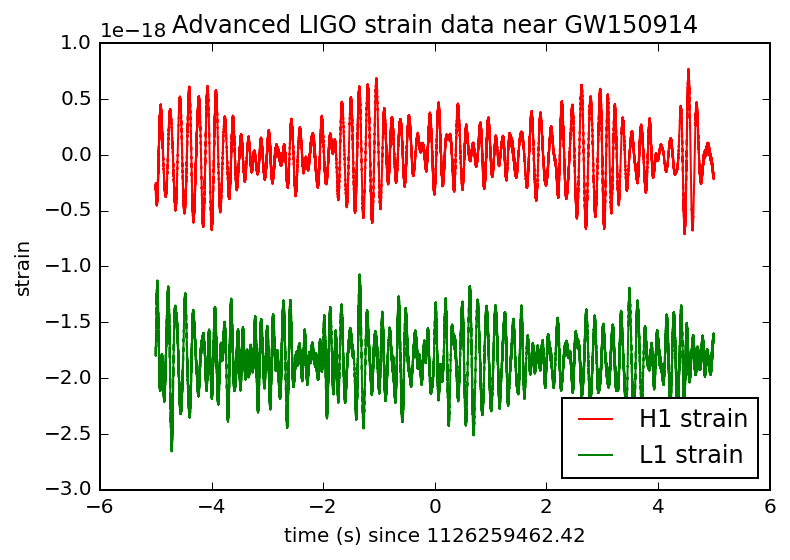

In [19]:
# plot +- 5 seconds around the event:
tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
deltat = 5.                     # seconds around the event
# index into the strain time series for this time interval:
# indxt = np.where((time_H1 >= tevent-deltat) & (time_H1 < tevent+deltat))

# ** Note they used np.where -- but you know that you don't have to!
# ** Try the following!
indxt = (time_H1 >= tevent-deltat) * (time_H1 < tevent+deltat)


plt.figure()
plt.plot(time_H1[indxt]-tevent,strain_H1[indxt],'r',label='H1 strain')
plt.plot(time_L1[indxt]-tevent,strain_L1[indxt],'g',label='L1 strain')
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('strain')
plt.legend(loc='lower right')
plt.title('Advanced LIGO strain data near GW150914')
plt.savefig('GW150914_strain.png')

The data are dominated by **low frequency noise**; there is no way to see a signal here, without some signal processing.

There are very low frequency oscillations that are putting the mean of the L1 strain at -2.0e-18 at the time around this event, so it appears offset from the H1 strain. These low frequency oscillations are essentially ignored in LIGO data analysis (see bandpassing, below).

We will be "whitening" the data, below. 

## Data in the Fourier domain - ASDs

Plotting these data in the Fourier domain gives us an idea of the frequency content of the data. A way to visualize the frequency content of the data is to plot the amplitude spectral density, ASD.

The ASDs are the square root of the power spectral densities (PSDs), which are averages of the square of the fast fourier transforms (FFTs) of the data.

They are an estimate of the "strain-equivalent noise" of the detectors versus frequency,
which limit the ability of the detectors to identify GW signals.

They are in units of strain/rt(Hz).
So, if you want to know the root-mean-square (rms) strain noise in a frequency band,
integrate (sum) the squares of the ASD over that band, then take the square-root.

There's a signal in these data! 
For the moment, let's ignore that, and assume it's all noise.

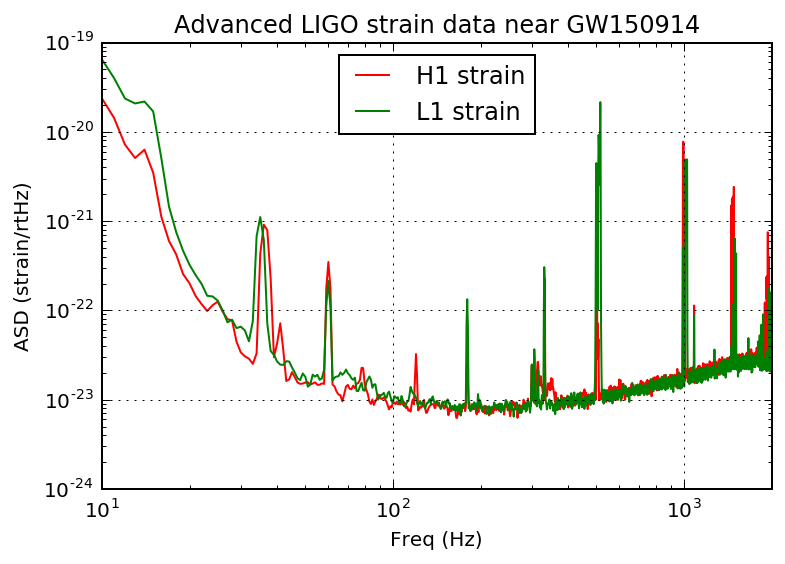

In [20]:
# number of sample for the fast fourier transform:
# ** We worked extensively with FFT in CP-I.
NFFT = 1*fs
fmin = 10
# ** Given that the samplin rate is 4096, the maximum detectable frequency 
# (Nyuqist frequency) is 2048.  Thus fmax = 2000.
fmax = 2000
# ** We have calculated FFT and then the power spectrum in CP-I
# ** another way of saying power spectrum is PSD (power spectral density)
Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

# We will use interpolations of the ASDs computed above for whitening:
# ** I mentioned whitening in an email related to facial recognition
psd_H1 = interp1d(freqs, Pxx_H1)
psd_L1 = interp1d(freqs, Pxx_L1)

# plot the ASDs:
plt.figure()
# ** Note: it's a log-log plot
plt.loglog(freqs, np.sqrt(Pxx_H1),'r',label='H1 strain')
plt.loglog(freqs, np.sqrt(Pxx_L1),'g',label='L1 strain')
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Advanced LIGO strain data near GW150914')
plt.savefig('GW150914_ASDs.png')

# ** Thus this thing squared is the variance/Hz.

NOTE that we only plot the data between fmin = 10 Hz and fmax = 2000 Hz.

Below fmin, the data **are not properly calibrated**. That's OK, because the noise is so high below fmin that LIGO cannot sense gravitational wave strain from astrophysical sources in that band.

## ** we spent quite a bit of time on Nyquist frequency = fs/2 in CP-II!
The sample rate is fs = 4096 Hz (2^12 Hz), so the data cannot capture frequency content above the Nyquist frequency = fs/2 = 2048 Hz. That's OK, because GW150914 only has detectable frequency content in the range 20 Hz - 300 Hz.

You can see strong spectral lines in the data; they are all of instrumental origin. Some are engineered into the detectors (mirror suspension resonances at ~500 Hz and harmonics, calibration lines, control dither lines, etc) and some (60 Hz and harmonics) are unwanted. We'll return to these, later.

You can't see the signal in this plot, since it is relatively weak and less than a second long, while this plot averages over 32 seconds of data. So this plot is entirely dominated by instrumental noise.

Later on in this tutorial, we'll look at the data sampled at the full 16384 Hz (2^14 Hz).

## Whitening

From the ASD above, we can see that the data are very strongly "colored" - noise fluctuations are much larger at low and high frequencies and near spectral lines, reaching a roughly flat ("white") minimum in the band around 80 to 300 Hz.

We can "whiten" the data (dividing it by the noise amplitude spectrum, in the fourier domain), suppressing the extra noise at low frequencies and at the spectral lines, to better see the weak signals in the most sensitive band.

Whitening is always one of the first steps in astrophysical data analysis (searches, parameter estimation).
Whitening requires no prior knowledge of spectral lines, etc; only the data are needed.

The resulting time series is no longer in units of strain; now in units of "sigmas" away from the mean.

In [21]:
# function to writen data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    # ** remember: we used np.fft in CP-I.
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

# now whiten the data from H1 and L1, and also the NR template:
strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
NR_H1_whiten = whiten(NR_H1,psd_H1,dt)

Now plot the whitened strain data, along with the best-fit numerical relativity (NR) template.

To get rid of remaining high frequency noise, we will also bandpass the data (see bandpassing, below).

The signal is now clearly visible in the whitened and bandpassed data. The "DC" offset between H1 and L1 data visible in the first plot is no longer visible here; the bandpassing cuts off frequency components below around 20 Hz and above 300 Hz. 

The signal is visible as an oscillation sweeping from low to high frequency from -0.10 seconds to 0, then damping down into the random noise. 

The signal looks roughly the same in both detectors. We had to shift the L1 data by 7 ms to get it to line up with the data from H1, because the source is roughly in the direction of the line connecting H1 to L1, and the wave travels at the speed of light, so it hits L1 7 ms earlier. Also, the orientation of L1 with respect to H1 means that we have to flip the sign of the signal in L1 for it to match the signal in H1.

It's exactly the kind of signal we expect from the inspiral, merger and ringdown of two massive black holes, as evidenced by the good match with the numerical relativity (NR) waveform, in black.

LIGO uses a rather elaborate software suite to match the data against a family of such signal waveforms ("templates"), to find the best match. This procedure helps LIGO to "optimally" separate signals from instrumental noise, and to infer the parameters of the source (masses, spins, sky location, orbit orientation, etc) from the best match templates.

## Spectrograms

Now let's plot a short time-frequency spectrogram around GW150914:

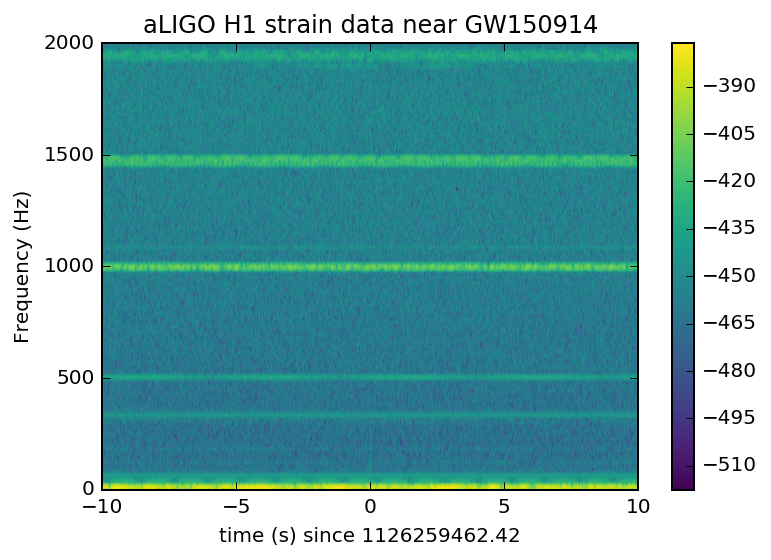

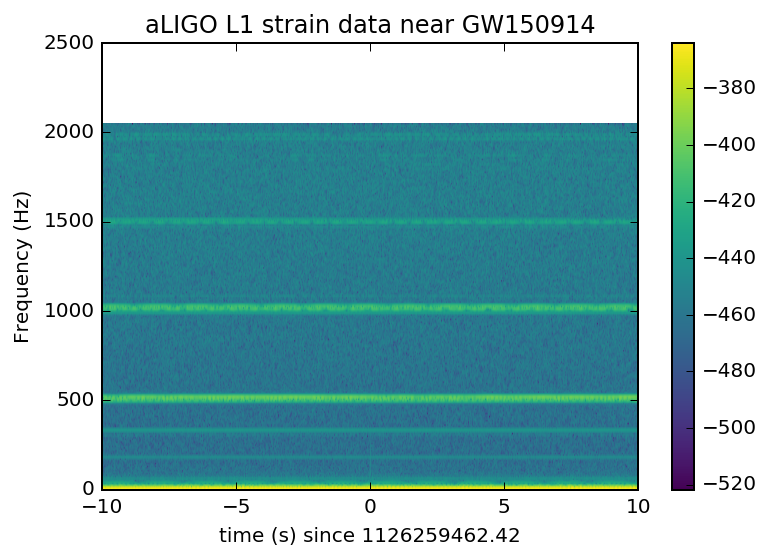

In [23]:
tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
deltat = 10.                    # seconds around the event
# index into the strain time series for this time interval:
indxt = np.where((time_H1 >= tevent-deltat) & (time_H1 < tevent+deltat))

# pick a shorter FTT time interval, like 1/8 of a second:
NFFT = fs/8
# and with a lot of overlap, to resolve short-time features:
NOVL = NFFT*15/16
# and choose a window that minimizes "spectral leakage" 
# (https://en.wikipedia.org/wiki/Spectral_leakage)
window = np.blackman(NFFT)

# ** We have also played a little bit with different colormaps in CP-I
# the right colormap is all-important! See:
# http://matplotlib.org/examples/color/colormaps_reference.html
# viridis seems to be the best for our purposes, but it's new; if you don't have it, 
# you can settle for ocean.
spec_cmap='viridis'
#spec_cmap='ocean'

# Plot the H1 spectrogram:
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_H1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-deltat, deltat, 0, 2000])
plt.title('aLIGO H1 strain data near GW150914')
plt.savefig('GW150914_H1_spectrogram.png')

# Plot the L1 spectrogram:
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_L1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.xlim(-deltat, deltat)
# plt.axis([-deltat, deltat, 0, 2000])
plt.title('aLIGO L1 strain data near GW150914')
plt.savefig('GW150914_L1_spectrogram.png')


In the above spectrograms, you can see lots of excess power below ~20 Hz, as well as strong spectral lines at 500, 1000, 1500 Hz (also evident in the ASDs above). The lines at multiples of 500 Hz are the harmonics of the "violin modes" of the fibers holding up the mirrors of the LIGO interferometers.

The signal is just bately visible here, at time=0 and below 500 Hz. We need to zoom in around the event time, and to the frequency range from [20, 400] Hz, and use the whitened data generated above.

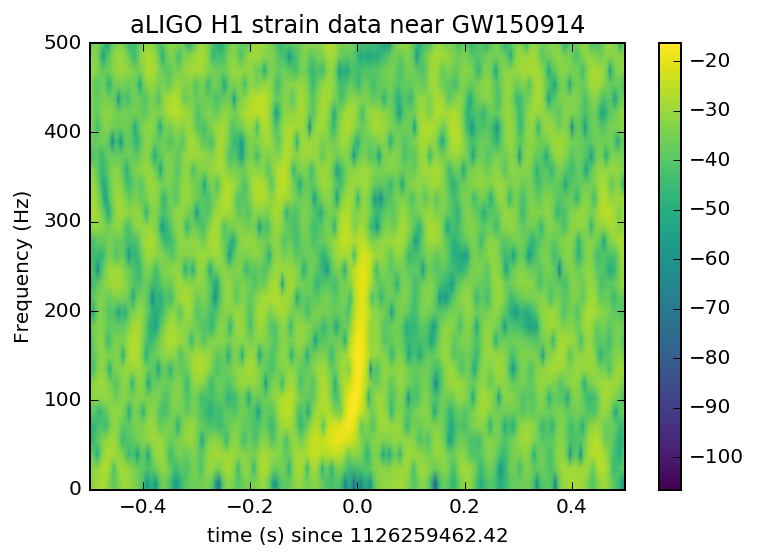

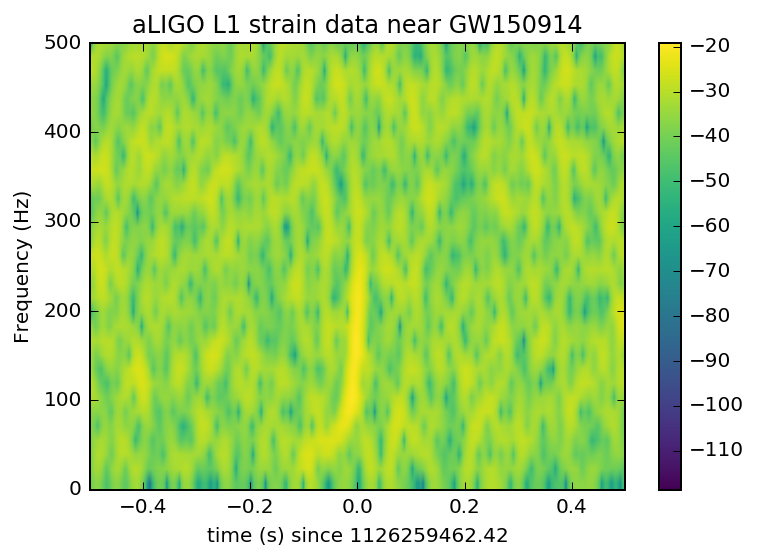

In [43]:
#  plot the whitened data, zooming in on the signal region:
tevent = 1126259462.422          # Mon Sep 14 09:50:45 GMT 2015 
deltat = 10.                      # seconds around the event
# index into the strain time series for this time interval:
indxt = np.where((time_H1 >= tevent-deltat) & (time_H1 < tevent+deltat))

n = 16
NFFT = fs/n

# and with a lot of overlap, to resolve short-time features:
NOVL = NFFT*15/16

# and choose a window that minimizes "spectral leakage" 
# (https://en.wikipedia.org/wiki/Spectral_leakage)
window = np.blackman(NFFT)

# Plot the H1 whitened spectrogram around the signal
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_H1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-0.5, 0.5, 0, 500])
plt.title('aLIGO H1 strain data near GW150914')
plt.savefig('GW150914_H1_spectrogram_whitened.png')

# Plot the L1 whitened spectrogram around the signal
plt.figure()
spec_L1, freqs, bins, im = plt.specgram(strain_L1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.xlim(-.5, 0.5)
plt.axis([-0.5, 0.5, 0, 500])
plt.title('aLIGO L1 strain data near GW150914')
plt.savefig('GW150914_L1_spectrogram_whitened.png')
# print('spect_H1.shape', spec_H1.shape)
# print('freq:', freqs.max(), freqs.min(), np.gradient(freqs)[0])
# print('bins:', bins.max(), bins.mean(), bins.min(), bins[1] - bins[0], len(bins), (bins.max() - bins.min())/(len(bins)-1))


See the smudge between -0.2 and 0 seconds? That's our signal!
You can see it 'chirping' from lower to higher frequency over a small fraction of a second.